## DataLoader & Preprocessing

In [ ]:
!nvidia-smi

Thu Nov 28 18:46:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 T...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P8               14W /  N/A|   1167MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm

In [ ]:
data=pd.read_csv('D:/pybaseball_data.csv')

In [ ]:
data.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,1655,FF,2024-09-01,87.8,-3.46,5.87,"Floro, Dylan",681624,571670,strikeout,...,14,3,14,Standard,Standard,234.0,0.0,-0.236,NaN,NaN
1,1727,SI,2024-09-01,90.0,-3.07,5.91,"Floro, Dylan",681624,571670,NaN,...,14,3,14,Standard,Standard,228.0,0.0,0.021,NaN,NaN
2,1760,FF,2024-09-01,87.1,-3.57,5.80,"Floro, Dylan",681624,571670,NaN,...,14,3,14,Standard,Standard,229.0,0.0,-0.075,70.02346,7.03039
3,1810,FF,2024-09-01,87.3,-3.34,5.79,"Floro, Dylan",681624,571670,NaN,...,14,3,14,Strategic,Standard,228.0,0.0,-0.044,NaN,NaN
4,1818,SI,2024-09-01,86.7,-3.25,5.94,"Floro, Dylan",500743,571670,field_out,...,14,3,14,Standard,Standard,228.0,0.0,-0.411,60.58697,5.44793


In [ ]:
data=data[['pitch_type', 'pitch_name',  'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'batter','zone', 'stand', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'pitch_number', 'spin_axis', 'delta_run_exp',
          'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'balls', 'strikes', 'game_pk', 'at_bat_number', 'bat_score', 'fld_score', 'pitch_number','zone', 'events'
]]
data.head()

,pitch_type,pitch_name,release_speed,release_pos_x,release_pos_z,pitcher,batter,zone,stand,p_throws,...,inning,balls,strikes,game_pk,at_bat_number,bat_score,fld_score,pitch_number,zone,events
0,FF,4-Seam Fastball,87.8,-3.46,5.87,571670,681624,3.0,R,R,...,9,1,2,747157,81,3,14,4,3.0,strikeout
1,SI,Sinker,90.0,-3.07,5.91,571670,681624,12.0,R,R,...,9,0,2,747157,81,3,14,3,12.0,NaN
2,FF,4-Seam Fastball,87.1,-3.57,5.80,571670,681624,5.0,R,R,...,9,0,1,747157,81,3,14,2,5.0,NaN
3,FF,4-Seam Fastball,87.3,-3.34,5.79,571670,681624,14.0,R,R,...,9,0,0,747157,81,3,14,1,14.0,NaN
4,SI,Sinker,86.7,-3.25,5.94,571670,500743,2.0,R,R,...,9,2,1,747157,80,3,14,4,2.0,field_out


In [ ]:
# 'on_3b', 'on_2b', 'on_1b' 칼럼의 NaN 여부를 0과 1로 변환
data['on_3b'] = data['on_3b'].notna().astype(int)
data['on_2b'] = data['on_2b'].notna().astype(int)
data['on_1b'] = data['on_1b'].notna().astype(int)

# 새로운 'score_diff' 칼럼을 생성하고 'fld_score - bat_score'로 계산
data['score_diff'] = data['fld_score'] - data['bat_score']
data = data.drop(columns=['fld_score', 'bat_score'])


In [ ]:
def calculate_cumulative_obp_slg(data):
    event_weights = {
        'single': (1, 1),
        'double': (1, 2),
        'triple': (1, 3),
        'home_run': (1, 4),
        'walk': (1, 0),
        'hit_by_pitch': (1, 0),
        'sac_fly': (1, 0),
        'field_error': (1, 0),
        'catcher_interf': (1, 0),
        'field_out': (0, 0),
        'strikeout': (0, 0),
        'force_out': (0, 0),
        'grounded_into_double_play': (0, 0),
        'fielders_choice': (0, 0),
        'fielders_choice_out': (0, 0),
        'truncated_pa': (0, 0),
        'strikeout_double_play': (0, 0),
        'sac_fly_double_play': (0, 0),
        'triple_play': (0, 0),
        'sac_bunt': (0, 0),
        'sac_bunt_double_play': (0, 0),
    }

    # events가 있는 행만 필터링
    events_data = data[data['events'].notna()].copy()
    events_data = events_data.sort_values(by=['game_pk', 'at_bat_number']).reset_index(drop=True)

    # 누적 OBP와 SLG 계산
    cumulative_obp = []
    cumulative_slg = []

    for idx, row in tqdm(events_data.iterrows(), total=len(events_data)):
        # 이전 타석 필터링
        prev_data = events_data[
            (events_data['pitcher'] == row['pitcher']) &
            (events_data['batter'] == row['batter']) &
            (
                (events_data['game_pk'] < row['game_pk']) |
                ((events_data['game_pk'] == row['game_pk']) & (events_data['at_bat_number'] < row['at_bat_number']))
            )
        ]

        if prev_data.empty:
            cumulative_obp.append(np.nan)
            cumulative_slg.append(np.nan)
            continue

        # 계산
        prev_data['on_base'], prev_data['total_bases'] = zip(*prev_data['events'].map(lambda x: event_weights.get(x, (0, 0))))
        total_plate_appearances = len(prev_data) - prev_data['events'].isin(['sac_bunt']).sum()
        total_at_bats = total_plate_appearances - prev_data['events'].isin(['walk', 'hit_by_pitch', 'sac_fly', 'sac_bunt']).sum()

        total_on_base = prev_data['on_base'].sum()
        total_bases = prev_data['total_bases'].sum()

        # OBP와 SLG 계산
        obp = total_on_base / total_plate_appearances if total_plate_appearances > 0 else 0
        slg = total_bases / total_at_bats if total_at_bats > 0 else 0

        cumulative_obp.append(obp)
        cumulative_slg.append(slg)

    # 누적 결과를 events_data에 추가
    events_data['cumulative_obp'] = cumulative_obp
    events_data['cumulative_slg'] = cumulative_slg
    events_data['cumulative_ops'] = events_data['cumulative_obp'] + events_data['cumulative_slg']

    # 복원
    data = data.merge(
        events_data[['game_pk', 'at_bat_number', 'pitcher', 'batter', 'cumulative_obp', 'cumulative_slg', 'cumulative_ops']],
        on=['game_pk', 'at_bat_number', 'pitcher', 'batter'],
        how='left'
    )
    data[['cumulative_obp', 'cumulative_slg', 'cumulative_ops']] = data.groupby(
        ['game_pk', 'at_bat_number', 'pitcher', 'batter']
    )[['cumulative_obp', 'cumulative_slg', 'cumulative_ops']].transform('ffill')

    return data

# 사용 예시
data = calculate_cumulative_obp_slg(data)

100%|██████████| 773167/773167 [1:17:32<00:00, 166.19it/s]


In [ ]:
data['cumulative_ops'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2944389 entries, 0 to 2944388
Series name: cumulative_ops
Non-Null Count    Dtype  
--------------    -----  
1822161 non-null  float64
dtypes: float64(1)
memory usage: 22.5 MB


In [ ]:
def calculate_game_obp_slg(data):
    # 이벤트 가중치 설정
    event_weights = {
        'single': (1, 1),   # (출루 여부, 루타)
        'double': (1, 2),
        'triple': (1, 3),
        'home_run': (1, 4),
        'walk': (1, 0),
        'hit_by_pitch': (1, 0),
        'sac_fly': (1, 0),
        'field_error': (1, 0),
        'catcher_interf': (1, 0),
        'field_out': (0, 0),
        'strikeout': (0, 0),
        'force_out': (0, 0),
        'grounded_into_double_play': (0, 0),
        'fielders_choice': (0, 0),
        'fielders_choice_out': (0, 0),
        'truncated_pa': (0, 0),
        'strikeout_double_play': (0, 0),
        'sac_fly_double_play': (0, 0),
        'triple_play': (0, 0),
        'sac_bunt': (0, 0),
        'sac_bunt_double_play': (0, 0),
    }

    # events가 있는 행만 필터링
    events_data = data[data['events'].notna()].copy()

    # 데이터 정렬
    events_data = events_data.sort_values(by=['game_pk', 'at_bat_number']).reset_index(drop=True)

    # 새로운 컬럼 초기화
    events_data['game_obp'] = np.nan
    events_data['game_slg'] = np.nan

    # 동일 game_pk 그룹으로 처리
    for game_pk, group in tqdm(events_data.groupby('game_pk'), desc="Processing games"):
        cumulative_on_base = 0
        cumulative_total_bases = 0
        cumulative_plate_appearances = 0
        cumulative_at_bats = 0

        for idx, row in group.iterrows():
            # 이전 타석까지 누적
            obp = cumulative_on_base / cumulative_plate_appearances if cumulative_plate_appearances > 0 else 0
            slg = cumulative_total_bases / cumulative_at_bats if cumulative_at_bats > 0 else 0

            # 현재 타석의 OPS 기록
            events_data.loc[idx, 'game_obp'] = obp
            events_data.loc[idx, 'game_slg'] = slg

            # 현재 타석 이벤트 값 추가
            on_base, total_bases = event_weights.get(row['events'], (0, 0))
            cumulative_on_base += on_base
            cumulative_total_bases += total_bases
            cumulative_plate_appearances += 1 - (row['events'] in ['sac_bunt'])
            cumulative_at_bats += 1 - (row['events'] in ['walk', 'hit_by_pitch', 'sac_fly', 'sac_bunt'])

    # OPS 계산
    events_data['game_ops'] = events_data['game_obp'] + events_data['game_slg']

    # 원본 데이터에 병합
    data = data.merge(
        events_data[['game_pk', 'at_bat_number', 'pitcher', 'batter', 'game_obp', 'game_slg', 'game_ops']],
        on=['game_pk', 'at_bat_number', 'pitcher', 'batter'],
        how='left'
    )

    # NaN 값이었던 누락된 행들에 대해 같은 타석 내에서 값 채우기
    data[['game_obp', 'game_slg', 'game_ops']] = data.groupby(
        ['game_pk', 'at_bat_number', 'pitcher', 'batter']
    )[['game_obp', 'game_slg', 'game_ops']].transform('ffill')

    return data

# 사용 예시
data = calculate_game_obp_slg(data)

Processing games: 100%|██████████| 10298/10298 [01:40<00:00, 102.69it/s]


In [ ]:
# NaN 값 대체
data['cumulative_obp'].fillna(data['cumulative_obp'].mean(), inplace=True)
data['cumulative_slg'].fillna(data['cumulative_slg'].mean(), inplace=True)
data['cumulative_ops'].fillna(data['cumulative_ops'].mean(), inplace=True)


data['game_obp'].fillna(data['game_obp'].mean(), inplace=True)
data['game_slg'].fillna(data['game_slg'].mean(), inplace=True)
data['game_ops'].fillna(data['game_ops'].mean(), inplace=True)

   cumulative_obp  cumulative_slg  cumulative_ops
0         0.32647        0.396643        0.723113
1         0.32647        0.396643        0.723113
2         0.32647        0.396643        0.723113
3         0.32647        0.396643        0.723113
4         0.00000        0.000000        0.000000


In [ ]:
#점수 차이 관련
data['winning']=data['score_diff'].apply(lambda x: 1 if x>0 else 0)
data['losing']=data['score_diff'].apply(lambda x: 1 if x<0 else 0)
data['tied']=data['score_diff'].apply(lambda x: 1 if x==0 else 0)
#세이브/홀드 상황 반영
data['tight']=data['score_diff'].apply(lambda x: 1 if abs(x)<=3 else 0)

In [ ]:
## 상황별
categorical_columns = ['pitch_type', 'stand', 'p_throws', 'on_3b', 'on_2b', 'on_1b']
numeric_columns = [col for col in data.columns if col not in categorical_columns and col != 'pitcher' and col != 'batter']

data_before_encoding = data.copy()
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

encoding_columns = list(set(data.columns) - set(data_before_encoding.columns))
data[encoding_columns] = data[encoding_columns].astype(int)

In [ ]:
data.columns

Index(['pitch_name', 'release_speed', 'release_pos_x', 'release_pos_z',
       'pitcher', 'batter', 'zone', 'balls', 'strikes', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'effective_speed', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'pitch_number', 'spin_axis', 'delta_run_exp',
       'outs_when_up', 'inning', 'balls', 'strikes', 'game_pk',
       'at_bat_number', 'pitch_number', 'zone', 'events', 'score_diff',
       'cumulative_obp', 'cumulative_slg', 'cumulative_ops', 'game_obp',
       'game_slg', 'game_ops', 'winning', 'losing', 'tied', 'tight',
       'pitch_type_CS', 'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FA',
       'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS',
       'pitch_type_KC', 'pitch_type_KN', 'pitch_type_PO', 'pitch_type_SC',
       'pitch_type_SI', 'pitch_type_SL', 'pitch_type_ST', 'pitch_type_SV',
       'stand_R', 'p_throws_R', 'on_3b_1', 'on_2b_1', 

In [ ]:
# 중복된 'outs_when_up' 열 제거 (하나만 남기기)
data = data.loc[:, ~data.columns.duplicated()]

# 'outs_when_up' 열을 int 형으로 변환
data['outs_when_up'] = data['outs_when_up'].astype(int)

In [ ]:
data['outs_when_up'].head()

0    2
1    2
2    2
3    2
4    1
Name: outs_when_up, dtype: int32

In [ ]:
# 주자 상황 및 아웃 카운트 조합
runner_states = [
    (0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1),
    (1, 1, 0), (1, 0, 1), (0, 1, 1), (1, 1, 1)
]
out_counts = [0, 1, 2]

# 새로운 이진 변수 생성
for outs in out_counts:
    for runners in runner_states:
        # 칼럼명 설정
        col_name = f"{outs}_outs_{runners[0]}-{runners[1]}-{runners[2]}"

        # 조건에 맞는 행에 1 할당, 나머지는 0
        data[col_name] = (
            (data['outs_when_up'] == outs) &
            (data['on_1b_1'] == runners[0]) &
            (data['on_2b_1'] == runners[1]) &
            (data['on_3b_1'] == runners[2])
        ).astype(int)

# 확인
print(data.head())


        pitch_name  release_speed  release_pos_x  release_pos_z  pitcher  \
0  4-Seam Fastball           87.8          -3.46           5.87   571670   
1           Sinker           90.0          -3.07           5.91   571670   
2  4-Seam Fastball           87.1          -3.57           5.80   571670   
3  4-Seam Fastball           87.3          -3.34           5.79   571670   
4           Sinker           86.7          -3.25           5.94   571670   

   batter  zone  balls  strikes  pfx_x  pfx_z  plate_x  plate_z  outs_when_up  \
0  681624   3.0      1        2  -0.63   0.88     0.72     3.34             2   
1  681624  12.0      0        2  -1.41   0.45     0.79     3.78             2   
2  681624   5.0      0        1  -0.50   1.26     0.00     2.89             2   
3  681624  14.0      0        0  -0.77   1.11     0.89     1.95             2   
4  500743   2.0      2        1  -1.09   0.73    -0.17     3.26             1   

         vx0         vy0       vz0         ax         ay

In [ ]:
# 낮은 스트라이크존 값 설정 (볼 제외)
low_zone_values = [7, 8, 9, 13, 14]  # 스트라이크존 값 중 낮은 부분

# 낮은 스트라이크존 여부를 나타내는 칼럼 생성
data['is_low_zone'] = data['zone'].isin(low_zone_values)

# 투수별 통계 계산 (player_name 포함)
pitcher_zone_stats = data.groupby(['pitcher']).agg(
    total_pitches=('zone', 'count'),        # 총 투구 수
    low_zone_pitches=('is_low_zone', 'sum') # 낮은 스트라이크존 투구 수
).reset_index()

# 투수별 낮은 스트라이크존 비율 계산
pitcher_zone_stats['low_zone_ratio'] = pitcher_zone_stats['low_zone_pitches'] / pitcher_zone_stats['total_pitches']

# 낮은 스트라이크존 비율을 원본 데이터에 추가
data = data.merge(
    pitcher_zone_stats[['pitcher', 'low_zone_ratio']],
    on='pitcher',
    how='left'
)

In [ ]:
data['low_zone_ratio'].fillna(data['low_zone_ratio'].mean(), inplace=True)

In [ ]:
data.head()

,pitch_name,release_speed,release_pos_x,release_pos_z,pitcher,batter,zone,balls,strikes,pfx_x,...,pitch_type_SL,pitch_type_ST,pitch_type_SV,stand_R,p_throws_R,on_3b_1,on_2b_1,on_1b_1,is_low_zone,low_zone_ratio
0,4-Seam Fastball,87.8,-3.46,5.87,571670,681624,3.0,1,2,-0.63,...,0,0,0,1,1,0,1,0,False,0.46665
1,Sinker,90.0,-3.07,5.91,571670,681624,12.0,0,2,-1.41,...,0,0,0,1,1,0,1,0,False,0.46665
2,4-Seam Fastball,87.1,-3.57,5.80,571670,681624,5.0,0,1,-0.50,...,0,0,0,1,1,0,1,0,False,0.46665
3,4-Seam Fastball,87.3,-3.34,5.79,571670,681624,14.0,0,0,-0.77,...,0,0,0,1,1,0,1,0,True,0.46665
4,Sinker,86.7,-3.25,5.94,571670,500743,2.0,2,1,-1.09,...,0,0,0,1,1,0,0,1,False,0.46665


In [ ]:
data.columns

Index(['pitch_name', 'release_speed', 'release_pos_x', 'release_pos_z',
       'pitcher', 'batter', 'zone', 'balls', 'strikes', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'effective_speed', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'pitch_number', 'spin_axis', 'delta_run_exp', 'inning',
       'game_pk', 'at_bat_number', 'events', 'score_diff', 'cumulative_obp',
       'cumulative_slg', 'cumulative_ops', 'game_obp', 'game_slg', 'game_ops',
       'winning', 'losing', 'tied', 'tight', 'pitch_type_CS', 'pitch_type_CU',
       'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC', 'pitch_type_FF',
       'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_KN',
       'pitch_type_PO', 'pitch_type_SC', 'pitch_type_SI', 'pitch_type_SL',
       'pitch_type_ST', 'pitch_type_SV', 'stand_R', 'p_throws_R', 'on_3b_1',
       'on_2b_1', 'on_1b_1', 'is_low_zone', 'low_zone_ratio'],
      dtype='object')

In [ ]:
data.to_csv('D:/pybaseball_data_1.csv', index=False)

## 결측치 제거 & 추가처리

In [ ]:
# 결측치가 있는 칼럼명 출력
missing_columns = data.columns[data.isnull().sum() > 0]
print("Columns with missing values:")
print(missing_columns.tolist())

Columns with missing values:
['pitch_name', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis', 'delta_run_exp', 'events']


In [ ]:
# 결측치를 채울 칼럼 목록 (평균으로 채움)
columns_to_fill = ['release_speed', 'effective_speed', 'release_spin_rate', 'release_extension',
                   'release_pos_x', 'release_pos_y',
                   'release_pos_z', 'spin_axis','zone','plate_x','plate_z',
                   'pfx_x','pfx_z','vx0','vy0','vz0','ax','ay','az', 'low_zone_ratio']

# pitcher_id 별, pitch_type 별로 그룹화하여 각 칼럼의 평균값을 구함
grouped_means = data.groupby(['pitcher', 'pitch_name'])[columns_to_fill].transform('mean')

# 각 칼럼의 결측치가 있으면 그룹의 평균값으로 채움
df_filled = data.copy()
for col in columns_to_fill:
    df_filled[col].fillna(grouped_means[col], inplace=True)

# 결측치가 잘 채워졌는지 확인
print(df_filled.isnull().sum())

pitch_name       74021
release_speed    74412
release_pos_x    74412
release_pos_z    74412
pitcher              0
                 ...  
2_outs_0-0-1         0
2_outs_1-1-0         0
2_outs_1-0-1         0
2_outs_0-1-1         0
2_outs_1-1-1         0
Length: 89, dtype: int64


In [ ]:
# delta_run_exp 칼럼을 drop하고, pitch_name이 결측치인 행들을 df2로 저장
df2 = df_filled[df_filled['pitch_name'].isnull()].copy()

# delta_run_exp 칼럼을 제거
df2 = df2.drop(columns=['delta_run_exp'])

# df2의 head 출력
print(df2.head())


      pitch_name  release_speed  release_pos_x  release_pos_z  pitcher  \
13063        NaN            NaN            NaN            NaN   676664   
21785        NaN            NaN            NaN            NaN   676979   
57588        NaN            NaN            NaN            NaN   669373   
57589        NaN            NaN            NaN            NaN   669373   
57590        NaN            NaN            NaN            NaN   669373   

       batter  zone  balls  strikes  pfx_x  pfx_z  plate_x  plate_z  \
13063  666969   NaN      1        0    NaN    NaN      NaN      NaN   
21785  543760   NaN      1        2    NaN    NaN      NaN      NaN   
57588  624431   NaN      2        2    NaN    NaN      NaN      NaN   
57589  624431   NaN      2        2    NaN    NaN      NaN      NaN   
57590  624431   NaN      1        2    NaN    NaN      NaN      NaN   

       outs_when_up  vx0  vy0  vz0  ax  ay  az  effective_speed  \
13063             2  NaN  NaN  NaN NaN NaN NaN              N

In [ ]:
# pitch_name, pfx_x, pfx_z가 결측치인 행들을 모두 삭제
#구종 데이터가 없는 칼럼의 경우, 매우 높은 확률로 세부 좌표값 또한 존재하지 않았음
df_cleaned = df_filled.dropna(subset=['pitch_name', 'pfx_x', 'pfx_z'])

# 결과 확인
print(df_cleaned.head())

        pitch_name  release_speed  release_pos_x  release_pos_z  pitcher  \
0  4-Seam Fastball           87.8          -3.46           5.87   571670   
1           Sinker           90.0          -3.07           5.91   571670   
2  4-Seam Fastball           87.1          -3.57           5.80   571670   
3  4-Seam Fastball           87.3          -3.34           5.79   571670   
4           Sinker           86.7          -3.25           5.94   571670   

   batter  zone  balls  strikes  pfx_x  pfx_z  plate_x  plate_z  outs_when_up  \
0  681624   3.0      1        2  -0.63   0.88     0.72     3.34             2   
1  681624  12.0      0        2  -1.41   0.45     0.79     3.78             2   
2  681624   5.0      0        1  -0.50   1.26     0.00     2.89             2   
3  681624  14.0      0        0  -0.77   1.11     0.89     1.95             2   
4  500743   2.0      2        1  -1.09   0.73    -0.17     3.26             1   

         vx0         vy0       vz0         ax         ay

In [ ]:
df_cleaned = df_cleaned.drop(columns=['events', 'delta_run_exp'])

In [ ]:
pd.set_option('display.max_columns', None)
df_cleaned1.isnull().sum()

pitch_name       0
release_speed    0
release_pos_x    0
release_pos_z    0
pitcher          0
                ..
2_outs_0-0-1     0
2_outs_1-1-0     0
2_outs_1-0-1     0
2_outs_0-1-1     0
2_outs_1-1-1     0
Length: 71, dtype: int64

In [ ]:
df_cleaned.columns

Index(['pitch_name', 'release_speed', 'release_pos_x', 'release_pos_z',
       'pitcher', 'batter', 'zone', 'balls', 'strikes', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'effective_speed', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'pitch_number', 'spin_axis', 'inning', 'game_pk',
       'at_bat_number', 'score_diff', 'cumulative_obp', 'cumulative_slg',
       'cumulative_ops', 'game_obp', 'game_slg', 'game_ops', 'winning',
       'losing', 'tied', 'tight', 'pitch_type_CS', 'pitch_type_CU',
       'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC', 'pitch_type_FF',
       'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_KN',
       'pitch_type_PO', 'pitch_type_SC', 'pitch_type_SI', 'pitch_type_SL',
       'pitch_type_ST', 'pitch_type_SV', 'stand_R', 'p_throws_R', 'on_3b_1',
       'on_2b_1', 'on_1b_1', 'is_low_zone', 'low_zone_ratio', '0_outs_0-0-0',
       '0_outs_1-0-0', '0_outs_0-1

In [ ]:
df_cleaned1 = df_cleaned.loc[:, ~df_cleaned.columns.str.startswith('pitch_type')]

In [ ]:
# 결측치가 있는 칼럼 목록
columns_to_fill = ['effective_speed', 'release_spin_rate', 'release_extension','spin_axis']

# 각 pitcher와 pitch_name별로 평균값을 계산
grouped_means = df_cleaned.groupby(['pitcher', 'pitch_name'])[columns_to_fill].transform('mean')
df_cleaned.update(df_cleaned[columns_to_fill].fillna(grouped_means))
print(df_cleaned.isnull().sum())


pitch_name       0
release_speed    0
release_pos_x    0
release_pos_z    0
pitcher          0
                ..
2_outs_0-0-1     0
2_outs_1-1-0     0
2_outs_1-0-1     0
2_outs_0-1-1     0
2_outs_1-1-1     0
Length: 87, dtype: int64


In [ ]:
# 결측치가 있는 칼럼명 출력
missing_columns = df_cleaned1.columns[df_cleaned1.isnull().sum() > 0]
print("Columns with missing values:")
print(missing_columns.tolist())

Columns with missing values:
['effective_speed', 'release_spin_rate', 'release_extension', 'spin_axis']


In [ ]:
missing_columns = ['effective_speed', 'release_spin_rate', 'release_extension', 'spin_axis']
missing_values_count = dat[missing_columns].isnull().sum()
print(missing_values_count)

effective_speed      0
release_spin_rate    0
release_extension    0
spin_axis            0
dtype: int64


In [ ]:
#구종에 대한 빈칸 처리 (구종이 없는 경우는 없다고 식별 후 투수의 구종별 평균 구속과 가장 유사한 구종으로 대체)
# pitch_type_으로 시작하는 칼럼들 중 값이 모두 0인 칼럼을 식별하고 count하는 코드

# 'pitch_type_'으로 시작하는 칼럼들만 추출, 0인 것들만 필터링
pitch_type_columns = [col for col in df_cleaned.columns if col.startswith('pitch_type')]
all_zero_columns = [col for col in pitch_type_columns if data[col].sum() == 0]

# 전체 0인 칼럼들의 개수
all_zero_columns_count = len(all_zero_columns)

all_zero_columns_count


0

In [ ]:
dat = df_cleaned1.dropna()
dat['pitcher'].nunique()

1940

In [ ]:
dat.to_csv('D:/pybaseball_data_cleaned.csv', index=False)

In [ ]:
'''2024년 첫 번째 게임의 game_pk: 744806
2023년 첫 번째 게임의 game_pk: 716352
2022년 첫 번째 게임의 game_pk: 661032
2021년 첫 번째 게임의 game_pk: 632169'''

In [ ]:
year_ranges = {
    2021: (632169, 661031),  # 2021년 범위
    2022: (661032, 716351),  # 2022년 범위
    2023: (716352, 744805),  # 2023년 범위
    2024: (744806, float('inf'))  # 2024년 범위
}

# game_pk를 기반으로 year 할당 함수
def assign_year(game_pk):
    for year, (start, end) in year_ranges.items():
        if start <= game_pk <= end:
            return year
    return None  # 예외 처리 (범위에 속하지 않는 경우)

# year 칼럼 생성
dat['year'] = dat['game_pk'].apply(assign_year)

# 결과 확인
print(dat[['game_pk', 'year']].head())


   game_pk  year
0   747157  2024
1   747157  2024
2   747157  2024
3   747157  2024
4   747157  2024


In [ ]:
dat['year'].value_counts()

year
2022    748712
2021    744027
2023    742807
2024    634266
Name: count, dtype: int64

In [ ]:
!pip install pybaseball
import pybaseball as pyb
from pybaseball import statcast, statcast_pitcher_pitch_arsenal

In [ ]:
arsenal_lst = []

for year in [2021, 2022, 2023, 2024]:
    df = statcast_pitcher_pitch_arsenal(year = year, minP = 1, arsenal_type = 'n_')
    df['year'] = year
    arsenal_lst.append(df)

ar_df = pd.concat(arsenal_lst)

In [ ]:
ar_df

,"last_name, first_name",pitcher,n_ff,n_si,n_fc,n_sl,n_ch,n_cu,n_fs,n_kn,n_st,n_sv,year
0,"Wheeler, Zack",554430,42.4,18.3,25.0,NaN,3.7,10.7,NaN,NaN,NaN,NaN,2021
1,"Mahle, Tyler",641816,53.0,NaN,4.9,26.2,NaN,NaN,15.9,NaN,NaN,NaN,2021
2,"Castillo, Luis",622491,28.5,23.6,NaN,17.4,30.5,NaN,NaN,NaN,NaN,NaN,2021
3,"Buehler, Walker",621111,44.7,7.4,16.0,0.0,4.8,13.2,NaN,NaN,13.9,NaN,2021
4,"Ray, Robbie",592662,59.2,0.3,NaN,30.8,3.6,6.1,NaN,NaN,NaN,NaN,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,"McKinstry, Zach",656716,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,2024
802,"Maile, Luke",571912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,2024
803,"Shreve, Chasen",592741,30.0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,30.0,NaN,2024
804,"Díaz, Miguel",622766,30.0,NaN,NaN,20.0,50.0,NaN,NaN,NaN,NaN,NaN,2024


In [ ]:
def process_pitch_type_data(df):
    """
    1. 구종 비율이 결측치가 아닌 값은 1로, 결측치는 0으로 변환합니다.
    2. 연 단위로 중복된 투수가 있을 때 구종 조합이 가장 많은 것을 기준으로 선택합니다.
    3. pitcher 열에서 중복된 투수가 있을 경우 중복을 삭제합니다.

    Parameters:
    df (pd.DataFrame): 연도별, 투수별 구종 비율을 포함한 데이터프레임.
                      'year', 'pitcher', 구종 비율 컬럼(pitch_freq_EP, pitch_freq_FA 등)을 포함해야 합니다.

    Returns:
    pd.DataFrame: 처리된 구종 조합 데이터를 반환합니다.
    """
    # 1. 구종 비율 결측치가 아닌 값은 1로, 결측치는 0으로 변환
    pitch_type_columns = [col for col in df.columns if col.startswith('n_')]
    df[pitch_type_columns] = df[pitch_type_columns].notnull().astype(int)

    # 2. 연 단위로 중복된 투수의 경우 구종 조합이 가장 많은 것을 선택
    df['pitch_type_count'] = df[pitch_type_columns].sum(axis=1)  # 구종 조합의 개수를 계산

    # 연도별, 투수별로 그룹화하고 pitch_type_count가 가장 많은 구종 조합 선택
    df = df.sort_values(['year', 'pitcher', 'pitch_type_count'], ascending=[True, True, False])
    df = df.drop_duplicates(subset=['year', 'pitcher'], keep='first').drop(columns=['pitch_type_count'])

    # 3. pitcher 열에서 중복된 투수 제거 (가장 처음 나오는 행만 남김)
    df = df.drop_duplicates(subset=['pitcher'], keep='first')

    return df

In [ ]:
ar_df_2 = process_pitch_type_data(ar_df)

In [ ]:
# n_으로 시작하는 칼럼 목록 가져오기
n_columns = [col for col in ar_df_2.columns if col.startswith('n_')]

# dat을 복사하여 dat1 생성 (원본 보존)
dat1 = dat.copy()

# dat1에 n_ 칼럼들 초기화 (값은 NaN으로)
for col in n_columns:
    if col not in dat1.columns:  # 중복 방지
        dat1[col] = np.nan

# pitcher와 year 기준으로 dat1에 n_ 칼럼 추가
for _, row in ar_df_2.iterrows():
    # pitcher가 같은 행 필터링
    matching_rows = dat1['pitcher'] == row['pitcher']

    # pitcher가 같은 행이 여러 개인 경우 year도 일치하는 행으로 추가 필터링
    if matching_rows.sum() > 1:
        matching_rows = matching_rows & (dat1['year'] == row['year'])

    # n_ 칼럼 데이터 업데이트
    for col in n_columns:
        dat1.loc[matching_rows, col] = row[col]

# 결과 확인
print(dat1.head())

        pitch_name  release_speed  release_pos_x  release_pos_z  pitcher  \
0  4-Seam Fastball           87.8          -3.46           5.87   571670   
1           Sinker           90.0          -3.07           5.91   571670   
2  4-Seam Fastball           87.1          -3.57           5.80   571670   
3  4-Seam Fastball           87.3          -3.34           5.79   571670   
4           Sinker           86.7          -3.25           5.94   571670   

   batter  zone  balls  strikes  pfx_x  pfx_z  plate_x  plate_z  outs_when_up  \
0  681624   3.0      1        2  -0.63   0.88     0.72     3.34             2   
1  681624  12.0      0        2  -1.41   0.45     0.79     3.78             2   
2  681624   5.0      0        1  -0.50   1.26     0.00     2.89             2   
3  681624  14.0      0        0  -0.77   1.11     0.89     1.95             2   
4  500743   2.0      2        1  -1.09   0.73    -0.17     3.26             1   

         vx0         vy0       vz0         ax         ay

In [ ]:
dat1.fillna(0, inplace=True)

In [ ]:
dat1['n_ff'].value_counts()

n_ff
0.0    1909143
1.0     960669
Name: count, dtype: int64

In [ ]:
def adjust_plate_and_zone(df):
    """
    Adjusts plate_x based on stand_R and creates a new_zone column based on adjusted plate_x and plate_y values.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing plate_x, plate_y, and stand_R columns.

    Returns:
    pd.DataFrame: Original DataFrame with adjusted_plate_x and new_zone columns added.
    pd.DataFrame: A separate DataFrame with only adjusted_plate_x, plate_y, and new_zone columns.
    """

    # 1. stand_R에 따라 plate_x 조정
    df['adjusted_plate_x'] = df.apply(lambda row: row['plate_x'] if row['stand_R'] == 1 else -row['plate_x'], axis=1)

    # 2. plate_x와 plate_y 값에 따라 new_zone 설정
    def assign_new_zone(row):
        if row['adjusted_plate_x'] > 0 and row['plate_z'] > 2.5:
            return 'out_high'
        elif row['adjusted_plate_x'] <= 0 and row['plate_z'] > 2.5:
            return 'in_high'
        elif row['adjusted_plate_x'] > 0 and row['plate_z'] <= 2.5:
            return 'out_low'
        else:
            return 'in_low'

    df['target_loc'] = df.apply(assign_new_zone, axis=1)
    df.drop('adjusted_plate_x', axis = 1, inplace = True)

    adj_df = df.loc[:, ['zone', 'stand_R', 'target_loc']]

    return df, adj_df

In [ ]:
df, com = adjust_plate_and_zone(dat1)

In [ ]:
df['target_loc'].value_counts()

target_loc
out_low     1002862
in_low       687730
out_high     663154
in_high      516066
Name: count, dtype: int64

In [ ]:
df.to_csv('D:/pybaseball_data_cleaned_v2.csv', index=False)

# Dataset

## Divide_Sequence_Pitch

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
df=pd.read_csv('D:/pybaseball_data_cleaned_v2.csv')

In [ ]:
df.columns

Index(['pitch_name', 'release_speed', 'release_pos_x', 'release_pos_z',
       'pitcher', 'batter', 'zone', 'balls', 'strikes', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'effective_speed', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'pitch_number', 'spin_axis', 'inning', 'game_pk',
       'at_bat_number', 'score_diff', 'cumulative_obp', 'cumulative_slg',
       'cumulative_ops', 'game_obp', 'game_slg', 'game_ops', 'winning',
       'losing', 'tied', 'tight', 'stand_R', 'p_throws_R', 'on_3b_1',
       'on_2b_1', 'on_1b_1', 'is_low_zone', 'low_zone_ratio', '0_outs_0-0-0',
       '0_outs_1-0-0', '0_outs_0-1-0', '0_outs_0-0-1', '0_outs_1-1-0',
       '0_outs_1-0-1', '0_outs_0-1-1', '0_outs_1-1-1', '1_outs_0-0-0',
       '1_outs_1-0-0', '1_outs_0-1-0', '1_outs_0-0-1', '1_outs_1-1-0',
       '1_outs_1-0-1', '1_outs_0-1-1', '1_outs_1-1-1', '2_outs_0-0-0',
       '2_outs_1-0-0', '2_outs_0-1-0', '2_outs_0-0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869812 entries, 0 to 2869811
Data columns (total 83 columns):
 #   Column             Dtype  
---  ------             -----  
 0   pitch_name         object 
 1   release_speed      float64
 2   release_pos_x      float64
 3   release_pos_z      float64
 4   pitcher            int64  
 5   batter             int64  
 6   zone               float64
 7   balls              int64  
 8   strikes            int64  
 9   pfx_x              float64
 10  pfx_z              float64
 11  plate_x            float64
 12  plate_z            float64
 13  outs_when_up       int64  
 14  vx0                float64
 15  vy0                float64
 16  vz0                float64
 17  ax                 float64
 18  ay                 float64
 19  az                 float64
 20  effective_speed    float64
 21  release_spin_rate  float64
 22  release_extension  float64
 23  release_pos_y      float64
 24  pitch_number       int64  
 25  spin_axis         

In [ ]:
numeric_columns = [
    'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
    'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension',
    'release_pos_y', 'spin_axis', 'score_diff', 'outs_when_up', 'inning', 'balls', 'strikes','at_bat_number',
    'pitch_number','zone', 'game_obp', 'game_slg', 'game_ops', 'cumulative_obp', 'cumulative_slg', 'cumulative_ops', 'low_zone_ratio'
]
encoding_columns = [
    'pitch_name', 'target_loc', 'winning', 'losing', 'tied', 'tight', 'p_throws_R', 'on_3b_1', 'on_2b_1',
      'on_1b_1','n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu','n_fs', 'n_kn', 'n_st', 'n_sv',
        'batter', 'pitcher'  # batter랑 pitcher는 시험삼아 넣어봄
]

# 업데이트된 target_columns (예측 대상으로 사용할 타겟 설정)
target_columns = ['pitch_name', 'target_loc']

In [ ]:
def divide_sequence_pitch(df, pitch_num_col='pitch_number', target_columns=['pitch_name', 'target_loc'], max_seq_len=20):
    sequences = []
    targets = []
    total_pitches = 0
    ignored_pitches = 0

    # 타석 단위로 그룹핑: game_pk, at_bat_number, inning 기준으로 그룹핑하여 타석 단위로 나눔
    player_group = df.groupby(['game_pk', 'at_bat_number', 'inning', 'pitcher', 'batter'], observed=True)

    for _, group in tqdm(player_group, desc="Processing at-bats", total=len(player_group)):
        group = group.sort_values(by=pitch_num_col)

        total_pitches += len(group)

        temp_sequence = []
        temp_target = []

        for i in range(len(group)):
            temp_sequence.append(group.iloc[i][numeric_columns + encoding_columns].values)
            temp_target.append(group.iloc[i][target_columns].values)

            if len(temp_sequence) >= max_seq_len:
                sequences.append(temp_sequence[:max_seq_len])
                targets.append(temp_target[:max_seq_len])
                ignored_pitches += len(temp_sequence) - max_seq_len
                temp_sequence = []
                temp_target = []

        if len(temp_sequence) > 0:
            if len(temp_sequence) > max_seq_len:
                ignored_pitches += len(temp_sequence) - max_seq_len
                temp_sequence = temp_sequence[:max_seq_len]
                temp_target = temp_target[:max_seq_len]

            sequences.append(temp_sequence)
            targets.append(temp_target)

    ignored_ratio = ignored_pitches / total_pitches * 100 if total_pitches > 0 else 0
    print(f"Total pitches: {total_pitches}, Ignored pitches: {ignored_pitches}, Ignored ratio: {ignored_ratio:.2f}%")

    return sequences, targets, ignored_ratio


In [ ]:
sequences, targets, ignored_ratio = divide_sequence_pitch(df)
print(f"Number of sequences: {len(sequences)}, Ignored ratio: {ignored_ratio:.2f}%")

Processing at-bats: 100%|██████████| 736898/736898 [35:52<00:00, 342.40it/s] 


Total pitches: 2869812, Ignored pitches: 0, Ignored ratio: 0.00%
Number of sequences: 736898, Ignored ratio: 0.00%


In [ ]:
seq_lengths = [len(seq) for seq in sequences]
max_len = max(seq_lengths)
min_len = min(seq_lengths)
avg_len = sum(seq_lengths) / len(seq_lengths)

# 출력
print(f"Number of sequences: {len(sequences)}, Ignored ratio: {ignored_ratio:.2f}%")
print(f"Max sequence length: {max_len}, Min sequence length: {min_len}, Avg sequence length: {avg_len:.2f}")

Number of sequences: 736898, Ignored ratio: 0.00%
Max sequence length: 17, Min sequence length: 1, Avg sequence length: 3.89


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import pickle

#from utils.args import pitch_sequence_parser
#from utils.utils import all_files_exist, divide_sequence_pitch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter

In [ ]:
class StatcastDataset(Dataset):
    def __init__(self, df, numeric_columns, encoding_columns, target_columns,
                 max_seq_len=20, use_col_list=None, scaler_mode='standard'):
        self.df = df
        self.numeric_columns = numeric_columns
        self.encoding_columns = encoding_columns
        self.target_columns = target_columns
        self.max_seq_len = max_seq_len

        if use_col_list is None:
            self.use_columns = ['pitch_name', 'release_speed', 'release_pos_x', 'release_pos_z',
       'pitcher', 'batter', 'zone', 'balls', 'strikes', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'effective_speed', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'pitch_number', 'spin_axis', 'inning', 'game_pk',
       'at_bat_number', 'score_diff', 'stand_R', 'p_throws_R', 'on_3b_1',
       'on_2b_1', 'on_1b_1', 'score_diff', 'inning', 'cumulative_obp', 'cumulative_slg', 'cumulative_ops',
       'game_obp', 'game_slg', 'game_ops', 'winning', 'losing', 'tied', 'tight' , 'low_zone_ratio'
       ,'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu','n_fs','n_kn','n_st','n_sv', 'target_loc']
        else:
            self.use_columns = use_col_list

        self.scaler_mode = scaler_mode
        self.int_columns = ['zone', 'balls', 'strikes', 'outs_when_up', 'pitch_number', 'inning', 'score_diff']
        self.cont_columns = [col for col in self.numeric_columns if col not in self.int_columns]

        self.__read_data__()
        self.__preprocess__()
        self.__devide_sequence__()
        self.__pad_sequence__()

    def __read_data__(self):
        # 필요 칼럼만 필터링
        self.df = self.df[self.use_columns]

        # 수치형 데이터와 범주형 데이터를 구분
        self.numeric_columns = numeric_columns
        self.encoding_columns = encoding_columns
        #self.numeric_columns = [col for col in self.df.columns if col not in ['pitcher', 'batter']]
        #self.encoding_columns = [col for col in self.df.columns if col.startswith('pitch_type_') or col.startswith('p_throws_') or col.startswith('stand_')]

        # 필터링된 데이터를 저장
        self.data = self.df.copy()

    def __preprocess__(self):
        # LabelEncoder를 사용해 pitch_name을 범주형 변수로 변환
        self.le = LabelEncoder()
        self.data['pitch_name'] = self.le.fit_transform(self.data['pitch_name'])

        # 수치형 데이터 정규화
        if self.scaler_mode == 'standard':
            self.scaler = StandardScaler()
        elif self.scaler_mode == 'minmax':
            self.scaler = MinMaxScaler()
        self.data[self.cont_columns] = self.scaler.fit_transform(self.data[self.cont_columns])

    def __devide_sequence__(self):
        # 시퀀스 분리 함수 실행 (이미 max_seq_len 적용됨)
        self.sequences, self.targets, self.ignored_ratio = divide_sequence_pitch(self.data,
                                                             pitch_num_col='pitch_number',
                                                             target_columns=self.target_columns,
                                                             max_seq_len=self.max_seq_len)

    def __pad_sequence__(self):
        # 텐서변환, 패딩
        seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in self.sequences]
        self.padded_sequences = pad_sequence(seq_tensors, batch_first=True, padding_value=0.0).permute(0, 2, 1)

        self.real_sequence_length = torch.tensor([len(seq) for seq in self.sequences])

        # 패딩 마스크 생성
        max_seq_len = self.padded_sequences.shape[-1]
        self.padding_mask = torch.zeros(self.padded_sequences.shape[0], max_seq_len, dtype=torch.bool)
        for i, length in enumerate(self.real_sequence_length):
            self.padding_mask[i, length:] = True

        target_tensors = [torch.tensor(tar_seq, dtype=torch.float32) for tar_seq in self.targets]
        self.padded_targets = pad_sequence(target_tensors, batch_first=True, padding_value=0.0)
        self.target_tensors = self.padded_targets

    def __len__(self):
        return len(self.padded_sequences)

    def __getitem__(self, index):
        return {
            "padded_data": self.padded_sequences[index],
            "real_sequence_length": self.real_sequence_length[index],
            "padding_mask": self.padding_mask[index],
            "targets": self.target_tensors[index]
        }

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

    def get_pitch_name_labels(self):
        # pitch_name 레이블 인코더에서 인덱스에 해당하는 pitch_name을 반환
        return list(self.le.classes_)


In [ ]:
# Dataset 인스턴스 생성
dataset = StatcastDataset(df, numeric_columns, encoding_columns, target_columns)

# DataLoader 생성
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# 첫 번째 배치 확인
for batch in dataloader:
    print("Batch padded_data shape:", batch['padded_data'].shape)
    print("Real sequence lengths:", batch['real_sequence_length'])
    print("Padding mask shape:", batch['padding_mask'].shape)
    print("Targets shape:", batch['targets'].shape)
    break  # 첫 번째 배치만 확인



NameError: name 'LabelEncoder' is not defined

In [ ]:
import random
def print_random_batches(dataloader, n=5):
    batches = list(dataloader)
    random_batches = random.sample(batches, n)

    for idx, batch in enumerate(random_batches):
        print(f"Batch {idx + 1}:")
        print("padded_data:", batch["padded_data"].shape)
        print("real_sequence_length:", batch["real_sequence_length"])
        print("padding_mask:", batch["padding_mask"].shape)
        print("targets:", batch["targets"].shape)
        print("=" * 50)

# 예시로 dataloader에서 5개의 랜덤 배치를 출력
print_random_batches(dataloader)

Batch 1:
padded_data: torch.Size([16, 41, 17])
real_sequence_length: tensor([6, 4, 1, 2, 6, 4, 5, 5, 4, 4, 4, 2, 1, 4, 1, 4])
padding_mask: torch.Size([16, 17])
targets: torch.Size([16, 17, 3])
Batch 2:
padded_data: torch.Size([16, 41, 17])
real_sequence_length: tensor([1, 5, 6, 4, 1, 6, 4, 4, 9, 5, 5, 1, 2, 3, 4, 1])
padding_mask: torch.Size([16, 17])
targets: torch.Size([16, 17, 3])
Batch 3:
padded_data: torch.Size([16, 41, 17])
real_sequence_length: tensor([4, 5, 1, 3, 4, 3, 2, 3, 2, 4, 4, 4, 5, 1, 5, 4])
padding_mask: torch.Size([16, 17])
targets: torch.Size([16, 17, 3])
Batch 4:
padded_data: torch.Size([16, 41, 17])
real_sequence_length: tensor([7, 3, 2, 6, 1, 2, 2, 3, 7, 2, 3, 4, 1, 5, 2, 2])
padding_mask: torch.Size([16, 17])
targets: torch.Size([16, 17, 3])
Batch 5:
padded_data: torch.Size([16, 41, 17])
real_sequence_length: tensor([3, 7, 7, 5, 1, 7, 5, 2, 6, 6, 2, 2, 3, 1, 3, 5])
padding_mask: torch.Size([16, 17])
targets: torch.Size([16, 17, 3])


## Prev_Version

# 장표용 코딩

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df=pd.read_csv('D:/pybaseball_data_cleaned.csv')

In [ ]:
# Pitcher별로 구종 평균 개수 구하기
pitcher_group = df.groupby('pitcher')['pitch_name'].nunique().mean()

print(f"Pitcher별 구종 평균 개수: {pitcher_group}")

Pitcher별 구종 평균 개수: 4.238144329896907


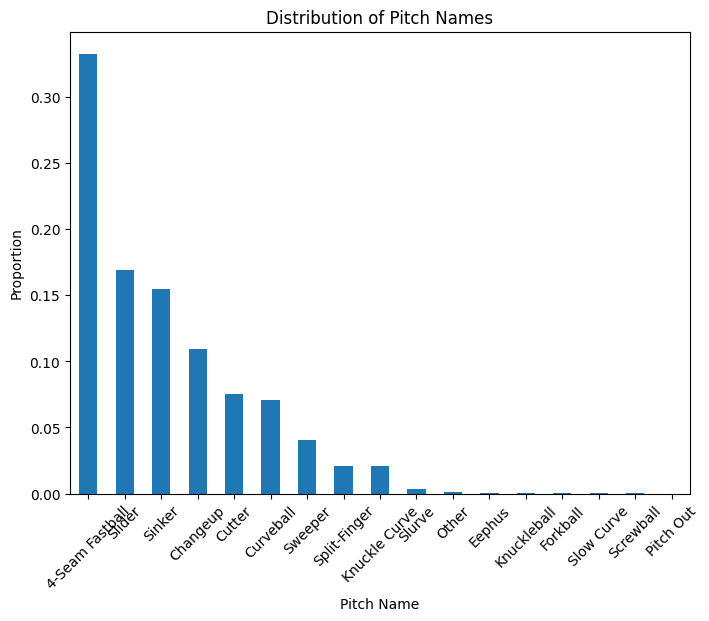

In [ ]:
pitch_name_counts = df['pitch_name'].value_counts(normalize=True)

# 시각화 (Pie chart 또는 Bar chart)
plt.figure(figsize=(8, 6))
pitch_name_counts.plot(kind='bar')
plt.title('Distribution of Pitch Names')
plt.ylabel('Proportion')
plt.xlabel('Pitch Name')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd

# 데이터 불러오기

# Pitcher별 구종 평균, 최소값, 최대값 구하기
pitcher_group_stats = df.groupby('pitcher')['pitch_name'].nunique().agg(['mean', 'min', 'max'])

print(pitcher_group_stats)


mean     4.238144
min      1.000000
max     11.000000
Name: pitch_name, dtype: float64


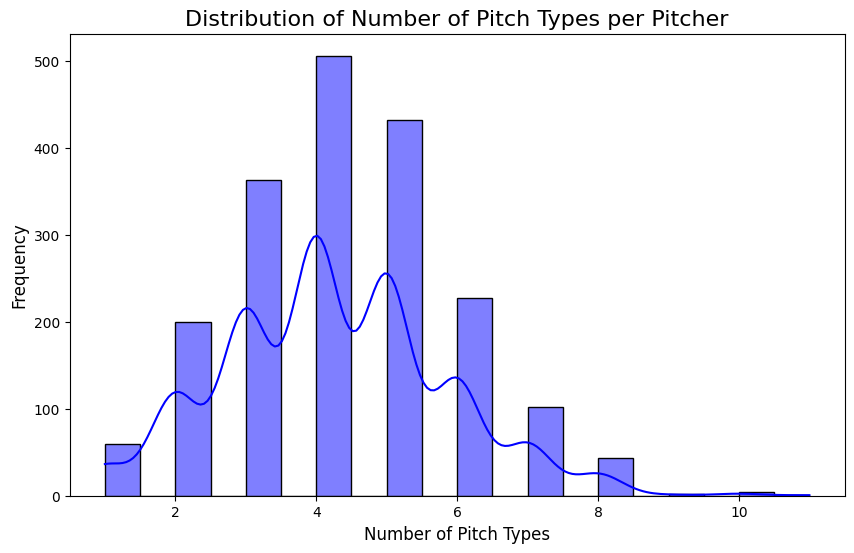

In [ ]:
# Pitcher별 구종 개수 구하기
pitcher_group_counts = df.groupby('pitcher')['pitch_name'].nunique()

# 히스토그램과 KDE 시각화
plt.figure(figsize=(10, 6))
sns.histplot(pitcher_group_counts, kde=True, bins=20, color='blue')

# 그래프 제목과 축 레이블 설정
plt.title('Distribution of Number of Pitch Types per Pitcher', fontsize=16)
plt.xlabel('Number of Pitch Types', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 그래프 표시
plt.show()